# Reading in the Weather Data -- may need to change wsubdir

In [1]:
import os as os
import datetime as dt
import fnmatch as fn
from operator import itemgetter

wsubdir = fn.filter(os.listdir('../../physmath248-2018/Part.II'), "w.*")
print("Weather subdirectories:", wsubdir)

Weather subdirectories: ['w.vic', 'w.sask']


In [2]:
## each file is of the form "key", "data" for several lines, then a blank space
## "Legend" then several (ignorable) lines, then a blank space
## "keys" separated by commas then
## remaining lines are the key values for each measurement. 

masterList = [] ## list of weather station dict objects

for wd in wsubdir:
    files = fn.filter(os.listdir('../../physmath248-2018/Part.II/'+wd), "eng-daily*.csv")
    for wdf in files:
        with open('../../physmath248-2018/Part.II/'+wd+'/'+wdf, encoding="utf-8") as f:
            blanks=0
            content = f.readlines()
            FD = dict() ## file dict head.
            FL = [] ## file list.
            keys = []
            for LN in content:
                PL = LN.replace(u'\ufeff','').split(",")
                for i in range(len(PL)): # this removes the quotes around the numbers.
                    PL[i] = PL[i].translate({ord(c): None for c in '"\n'})
                if len(PL)==1 and PL[0]=='':
                    blanks+=1
                    if blanks==2 and PL[0]=='':
                        continue
                ## if blanks==0 we need to build the main dict
                ## if blanks==1 we ignore
                ## if blanks==2 we build the data.
                if blanks==0:
                    FD[PL[0]] = PL[1]
                    if PL[0]=="Station Name":
                        FD["Data"] = []
                if blanks==2:
                    if PL[0]=="Date/Time":
                        keys = PL
                    else:
                        FD["Data"].append( { keys[i] : PL[i] for i in range(len(keys)) } )
            masterList.append(FD)        

## make set of "Station Name"s. 
## use it to merge common station names into one (more useful) masterList.
sNames = { x['Station Name'] for x in masterList}
print("Station names:", sNames)

## return index of list of dict if dict keyed-element exists, -1 otherwise
def indIfExists(LOD, keyname, value):
    for i in range(len(LOD)):
        if LOD[i][keyname] == value:
            return i
    return -1

## run through masterlist, if that airport exists in mList we merge, if not, we copy it over.
mList = []
while len(masterList)>0:
    I = indIfExists(mList, 'Station Name', masterList[-1]['Station Name'])
    if I<0:
        mList.append(masterList.pop())
    else:
        mList[I]["Data"].extend(masterList.pop()["Data"])

## run through the weather station data, replace the date record with a datetime object
for WS in mList:
    badItems = set()
    for i in range(len(WS["Data"])):
        ## Let's convert the dict from strings to appropriate datetime and float objects
        ## dates with bad data we will flag and remove.
        for key, value in WS["Data"][i].items():
            if key=="Date/Time":
                WS["Data"][i][key] = dt.datetime.strptime(value, "%Y-%m-%d")
            elif key in [ 'Min Temp (°C)', 'Total Precip (mm)',  \
                          'Max Temp (°C)', 'Mean Temp (°C)']:
                try:
                    WS["Data"][i][key] = float(value)
                except:
                    badItems.add( i )
    #print(len(WS["Data"]), end=" ")
    WS["Data"] = [WS["Data"][i] for i in range(len(WS["Data"])) if i not in badItems]
    #print(len(WS["Data"]), "\n")
    WS["Data"] = sorted(WS["Data"], key=itemgetter("Date/Time"))

Station names: {"SASKATOON DIEFENBAKER INT'L A", "VICTORIA INT'L A", 'VICTORIA INTL A', 'SASKATOON SRC'}


In [3]:
#temp victoria and saskatoon arrays to hold the info until we can whittle down the common dates
vtemp = []
stemp = []

#combine the two victoria stations and the two saskatoon stations together
for x in mList:
    if 'VICTORIA' in x['Station Name']:
        for y in x['Data']:
            vtemp.append(y)
            
    if 'SASKATOON' in x['Station Name']:
        for y in x['Data']:
            stemp.append(y)

print(len(vtemp), len(stemp)) #yikes big difference

#sort the two arrays by date to be able to compare the common ones.
sorted(vtemp, key = lambda x: x['Date/Time'])
sorted(stemp, key = lambda x: x['Date/Time'])

17304 15107


[{'Cool Deg Days (°C)': '0.0',
  'Cool Deg Days Flag': '',
  'Data Quality': '',
  'Date/Time': datetime.datetime(1970, 1, 1, 0, 0),
  'Day': '01',
  'Dir of Max Gust (10s deg)': '',
  'Dir of Max Gust Flag': '',
  'Heat Deg Days (°C)': '33.6',
  'Heat Deg Days Flag': '',
  'Max Temp (°C)': -13.3,
  'Max Temp Flag': '',
  'Mean Temp (°C)': -15.6,
  'Mean Temp Flag': '',
  'Min Temp (°C)': -17.8,
  'Min Temp Flag': '',
  'Month': '01',
  'Snow on Grnd (cm)': '18',
  'Snow on Grnd Flag': '',
  'Spd of Max Gust (km/h)': '<31',
  'Spd of Max Gust Flag': '',
  'Total Precip (mm)': 0.5,
  'Total Precip Flag': '',
  'Total Rain (mm)': '0.0',
  'Total Rain Flag': '',
  'Total Snow (cm)': '1.0',
  'Total Snow Flag': '',
  'Year': '1970'},
 {'Cool Deg Days (°C)': '0.0',
  'Cool Deg Days Flag': '',
  'Data Quality': '',
  'Date/Time': datetime.datetime(1970, 1, 2, 0, 0),
  'Day': '02',
  'Dir of Max Gust (10s deg)': '',
  'Dir of Max Gust Flag': '',
  'Heat Deg Days (°C)': '30.5',
  'Heat Deg Day

In [4]:
#these arrays will hold ALL the data for each day that the two cities have in common
# that way, I can just pull a specific key straight from them and save elsewhere instead of 
# repeating the same thing over and over again.
vic = []
sask = []

#appending the info from ONLY the common dates to the corresponding array, either vic or sask, as declared above.
count=0
for i in range(len(stemp)):
    if stemp[i]['Date/Time'] == vtemp[count]['Date/Time']: #easiest case. if dates are the same, append.
        vic.append(vtemp[count])
        sask.append(stemp[i])
        count+=1
    while stemp[i]['Date/Time'] > vtemp[count]['Date/Time']: #if stemp's date is higher, keep traversing vtemp
                                                             #until the dates are equal or vtemp's is higher.
        count+=1
        if stemp[i]['Date/Time'] == vtemp[count]['Date/Time']:
            vic.append(vtemp[count])
            sask.append(stemp[i])
            count+=1
        # note: no need to do anything if stemp < vtemp, bc the for loop will iterate and count will 
        # stay the same. This will repeat until another case is reached.

#print(len(vic), len(sask)) #wahoo, same length!
print("\n\nCommon data:", len(vic))


### just to check if the date really is lined up for both datasets
count = 0
for i in vic:
    if i['Date/Time'] != sask[count]['Date/Time']:
        print("yikes! ur code is messed up, girl!") #nothing should be printed if all is good.
    count+=1



Common data: 15055


## Daily Precip

In [5]:
#this are the two data sets we will eventually plot against each other.
#need to isolate the total precip from the rest of the keys from each element in vic and sask.
vic_precip = []
sask_precip = []

for i in vic:
    vic_precip.append(i['Total Precip (mm)'])

for i in sask:
    sask_precip.append(i['Total Precip (mm)'])

#print(len(vic_precip), len(sask_precip)) #just a check
#print(vic_precip[15054], sask_precip[15054]) #just a check

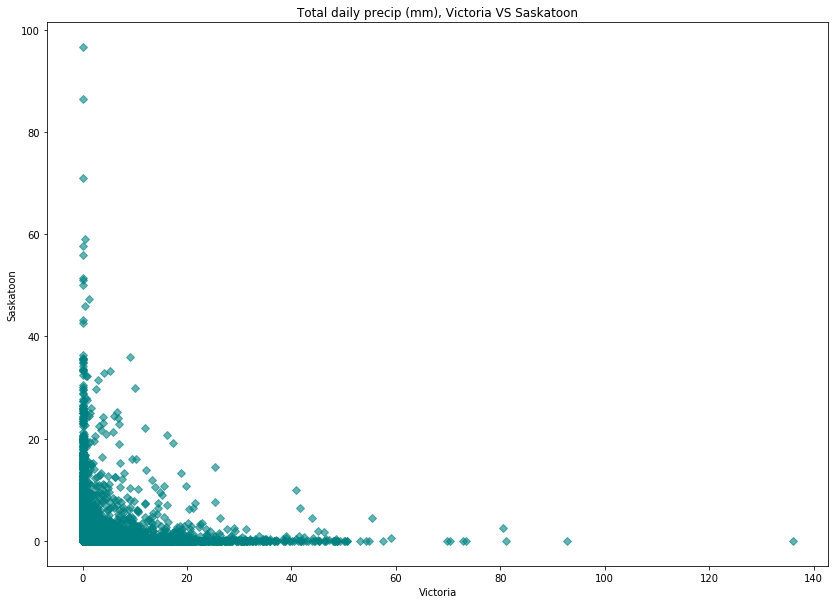

In [6]:
#plotting time, baby!!!!
plt.figure(figsize = (14,10))
plt.plot(vic_precip, sask_precip, 'D', alpha = 0.60, color = 'teal')
plt.xlabel("Victoria")
plt.ylabel("Saskatoon")
plt.title("Total daily precip (mm), Victoria VS Saskatoon")


## Daily Mean Temp

In [7]:
#need to pull daily mean temp from each city and save to an array
vic_mtemp = []
sask_mtemp = []

for i in vic:
    vic_mtemp.append(i['Mean Temp (°C)'])

for i in sask:
    sask_mtemp.append(i['Mean Temp (°C)'])

#print(len(vic_mtemp), len(sask_mtemp)) #just checking all dates are still present

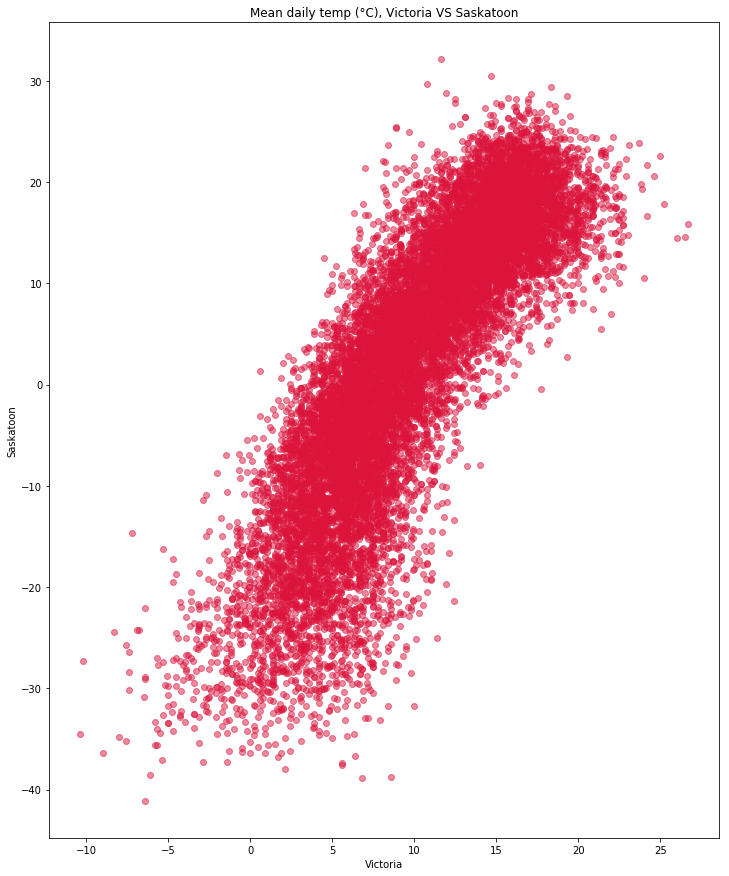

In [9]:
#plotting time part dos!
plt.figure(figsize=(12,15))

#
plt.plot(vic_mtemp, sask_mtemp, 'o', alpha = 0.5, color = 'crimson')

#linear least squares
##plt.plot([min(vic_mtemp), max(vic_mtemp)], [c0+c1*min(vic_mtemp), c0+c1*max(vic_mtemp)], color="black",\
  #       label=str("%1.1f + %1.1f x" % (c0,c1)))

#plt.legend(loc='upper left')
plt.xlabel("Victoria")
plt.ylabel("Saskatoon")
plt.title("Mean daily temp (°C), Victoria VS Saskatoon")
plt.show()

## LINEAR LEAST SQUARES

In [12]:
# linear least squares interpolation
A = np.matrix([[1.0, x] for x in vic_mtemp]).T
y = np.matrix([y for y in sask_mtemp]).T

c = np.matmul(np.matmul(np.linalg.inv(np.matmul(A,A.T)), A), y)
c0=c[0,0]
c1=c[1,0]
print(c)
print("\n\nThe linear least squares coefficients are:", c0, "and", c1)

[[-19.50239038]
 [  2.2183622 ]]


The linear least squares coefficients are: -19.5023903754 and 2.218362197


## QUADRATIC LEAST SQUARES

In [11]:
## what happens if we put in a quadratic term?

A = np.matrix([[1.0, x, x*x] for x in vic_mtemp]).T
y = np.matrix([y for y in sask_mtemp]).T

c = np.matmul(np.matmul(np.linalg.inv(np.matmul(A,A.T)), A), y) 

print(c)

[[-22.17791048]
 [  2.99494316]
 [ -0.03978577]]
